In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from models.ctc_loss import CTCLoss
from models.accuracy import WordAccuracy
from models.decode import Decoder
from models.config import BATCH_SIZE, BUFFER_SIZE, WORK_PATH,TEST_PATH, is_save_model, TABLE_PATH, export_path
from models.data_prepare import load_and_preprocess_image, decode_label, get_image_path,load_and_preprocess_image_pridict,load_and_preprocess_image_draw
import numpy as np
import random
import json
import time
import os

## 构造数据集

In [2]:
#测试数据集
test_all_image_paths = [TEST_PATH + img for img in sorted(os.listdir(TEST_PATH))]

In [3]:
test_images_num = len(test_all_image_paths)
test_steps_per_epoch = test_images_num
test_ds = tf.data.Dataset.from_tensor_slices(test_all_image_paths)
test_ds = test_ds.map(load_and_preprocess_image_pridict, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(2)
test_ds = test_ds.apply(tf.data.experimental.ignore_errors())
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

## 模型加载

In [4]:
model = tf.keras.models.load_model(WORK_PATH + 'output/crnn_15.h5', compile=False)

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=CTCLoss(), metrics=[WordAccuracy()])

## 模型测试

In [6]:
test_data = next(iter(test_ds))

In [7]:
result = model.predict(test_data)

In [8]:
with open(TABLE_PATH, 'r',encoding='gbk') as f:
    inv_table = [char.strip() for char in f]+[' ']*2
    
decoder = Decoder(inv_table)

---------------------------------------


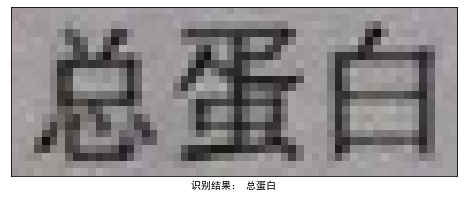

---------------------------------------


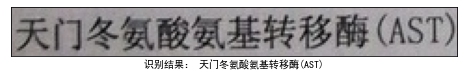

In [9]:
y_pred = decoder.decode(result, method='greedy')

for i,sentense in enumerate(y_pred):
    print('---------------------------------------')
    plt.figure(figsize=(8,18))
    plt.subplot(len(y_pred),1,i+1)
    plt.imshow(load_and_preprocess_image_draw(test_all_image_paths[i]))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('识别结果： '+sentense)
    plt.show()
    

## 保存模型

In [10]:
#is_save_model = True
if is_save_model:
    tf.keras.models.save_model(
                                model,
                                export_path,
                                overwrite=True,
                                include_optimizer=True,
                                save_format=None,
                                signatures=None,
                                options=None
                              )
    print('模型保存成功。')

## 查看已保存的模型信息

In [11]:
#!saved_model_cli show --dir {export_path} --all

In [12]:
(3360-2800)

560